# Identify human physical movements

## *Acquisition of the characteristics*

A machine learning algorithm does not sort directly from raw data. This classification is done through an analysis in a dataset that is constructed using resource variables. The choice of resources that represent a high level of information is a fundamental step in the development of a pattern recognition model.

In this stage of the project, the acquisition of the resources will be demonstrated, which were extracted from the raw data of the sensors (Aceleromêtro and Giroscopio).

----
## Pré-processamento dos dados

The sensor data was stored in a CSV file. This file contains the following information:

- Time interval
- Activity performed
- Time series of each axis (x, y, z) of acceleration and rotation.

**File structure**

The file structure is divided into 7 lines, each line with a comma-separated type of information.

* **Line 1:** Activity and Time
* **Line 2:** Accelerometer X-axis time series
* **Line 3:** Accelerometer Y-axis time series
* **Line 4:** Accelerometer Z-axis time series
* **Line 5:** Gyroscope X-axis time series
* **Line 6:** Gyroscope Y-axis time series
* **Line 7:** Gyroscope Z-axis time series

## Selected Features

To select the following features, a study of articles related to signal processing was done, which shows the best characteristics we can extract from a time series.

The resources below have produced a good ranking result. The following will be explained in more detail each, and how to extract them from the raw data.

- Time Step
- Frequency
- Mean of each axis of acceleration and rotation
- Variance of each axis of acceleration and rotation
- Magnitude of acceleration vector
- Magnitude of the fast Fourier transform of the acceleration

----
## Data processing

### Preparing the data

The code below loads the required Python libraries and loads the data from the sensors.

In [101]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from io import StringIO

# Position of each information in the file
idxLabel_time = 0 # Activity and time step
idxAccX = 0 # accelerometer X axis
idxAccY = 1 # accelerometer Y axis
idxAccZ = 2 # accelerometer Z axis
idxRotX = 3 # gyroscope X axis
idxRotY = 4 # gyroscope Y axis
idxRotZ = 5 # gyroscope Z axis

label_time = []
series = []

# Reads the file with the sensor data
with open('../data/movs/0a05c36147.csv', 'r') as file:
    
    # Reads all lines of file
    lines = file.readlines()
    
    # Retrieve information about activity and time.
    # Transform Row into a String Buffer
    # to convert the contents to an array
    x = StringIO(lines[idxLabel_time])
        
    # Converts data from the first row that is separated by
    # comma in numpy array
    label_time = np.genfromtxt(x, delimiter=',', dtype=str)        
    
    # Delete the first line of the list
    del lines[idxLabel_time]
    
    # Read the rest of the lines with the time series of each
    # comma-separated axis and converts to an array
    series = np.genfromtxt(lines, delimiter=',', dtype=float)
        
print(label_time)
print(series[:-5])

['andando_passos_longos' '5']
[[ 0.         18.51675606  6.82826328  2.00634098 11.10909557 14.75785923
   4.92247868  8.98783302 13.8911581   9.52413464  8.03494072  4.16591072
   5.46356821 11.583148   12.20563984 12.02846909  1.59932673 10.0269165
   8.85375786 10.6446209  10.76433086  9.13148499 -0.1340753  12.67490387
  12.44506073 11.5927248  13.48893261 14.4849205  16.34282112]]


In [102]:
label = label_time[0]
time_step = (float(label_time[1]) / 100)

print("Activity: {}".format(label))
print("Time step: {} seg".format(time_step))

Activity: andando_passos_longos
Time step: 0.05 seg


### Frequency

The `frequency` gives the number of occurrences repeated in a time interval. This parameter is very important because it gives the rate of oscillations and vibrations of physical movement.

**Calculate the frequency by the fast Fourier transform**

The `frequency` of a signal can be obtained by converting the time domain to that of the `frequency` using the [fast Fourier transform](http://mathworld.wolfram.com/FastFourierTransform.html) (FFT), which efficiently computes the [discrete Fourier transform](http://mathworld.wolfram.com/DiscreteFourierTransform.html). The Fourier transform is an [integral transform](https://pt.wikipedia.org/wiki/Transformada_integral) which modifies a time signal in frequencies using sinusoidal components.

The FFT can be calculated using the library **[SciPy](https://docs.scipy.org/doc/scipy/reference/fftpack.html)**, as shown in the code block below.

In [103]:
from scipy import fftpack as ft

# Function to calculate the fast Fourier transform
def calculateTransformFourier(series):    
    n = len(series) # Number of points
    
    # Returns the discrete Fourier transform
    return ft.fft(np.exp(2j * np.pi * series / n))

In [104]:
def calculateFrequency(series, time_step):    
           
    # Calculates the sample frequencies of the discrete Fourier transform
    # within a time step
    frequency = ft.fftfreq(series.size, d=time_step)
    
    # Returns the amount of frequency peaks
    peaks = np.where(frequency > 0)    
    
    # Returns the frequency peaks
    frequencys = frequency[peaks]  
    
    # Returns the maximum frequency
    return frequencys[:len(frequencys)]


# Applies the function to calculate the frequency of each axis of the sensors.
frequency = np.max(calculateFrequency(series[0], time_step))

print("Frequency: {}".format(frequency))

Frequency: 9.655172413793103


### Mean of each axis (Acceleration and Rotation)

The `mean` shows the concentration that the data of each axis of acceleration and rotation has on a physical activity.

In [105]:
from scipy import stats

def calculateMean(series):        
    return np.mean(series)

def evaluate(series, value, title, xlabel, ylabel, rows, cols, currentCol):
    hist = sorted(series)
    fit = stats.norm.pdf(hist, value, np.std(series))
    
    plt.subplot(rows, cols, currentCol)
    plt.title(title)
    plt.plot(hist, fit, '-o')    
    plt.hist(hist, density=True, color='#d8dcd6')     
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    
def evaluateVar(serie, var, title, rows, cols, currentCol):
    evaluate(serie, var, title, 'Variance', 'Density',  rows, cols, currentCol)
    
def evaluateMean(serie, mean, title, rows, cols, currentCol):
    evaluate(serie, mean, title, 'Mean', 'Density',  rows, cols, currentCol)

Mean of Acceleration
-----
X-axis: 9.51521801075031
Y-axis: -3.4758855474406274
Z-axis: 2.5707121368112236


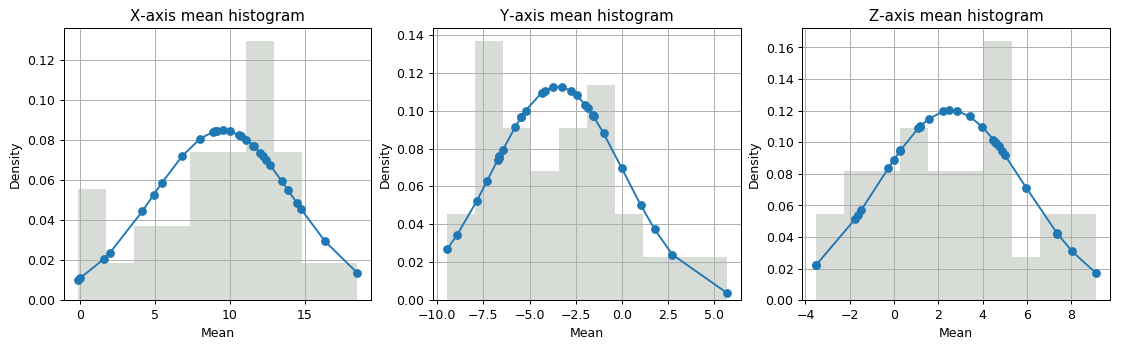

In [110]:
# Calculates the mean for all acceleration axes
mnAccX = calculateMean(series[idxAccX])
mnAccY = calculateMean(series[idxAccY])
mnAccZ = calculateMean(series[idxAccZ])

print("Mean of Acceleration\n-----");
print("X-axis: {}".format(mnAccX))
print("Y-axis: {}".format(mnAccY))
print("Z-axis: {}".format(mnAccZ))

%matplotlib inline
plt.figure(figsize=(15, 4), dpi=90)

evaluateMean(series[idxAccX], mnAccX, 'X-axis mean histogram', 1, 3, 1)
evaluateMean(series[idxAccY], mnAccY, 'Y-axis mean histogram', 1, 3, 2)
evaluateMean(series[idxAccZ], mnAccZ, 'Z-axis mean histogram', 1, 3, 3)

Mean Rotation
-----
X-axis: -0.08217481600827184
Y-axis: -0.0911747238373962
Z-axis: 0.005142825430837171


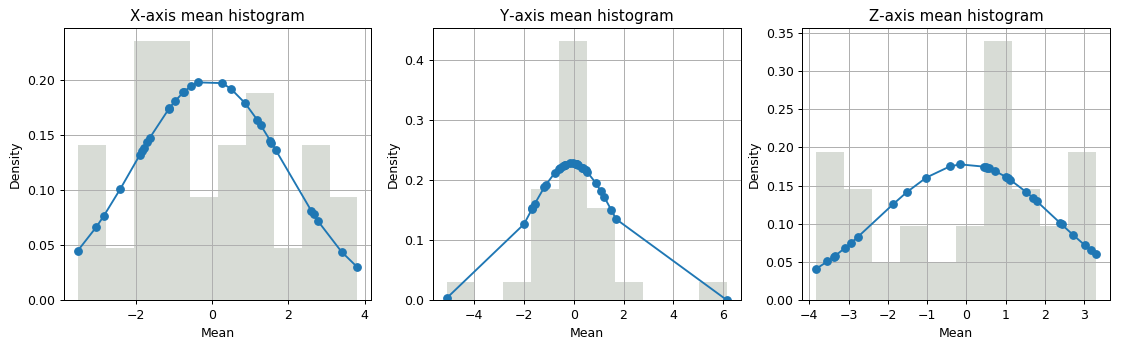

In [107]:
# Calculates the mean for all axes of rotation
mnRotX = calculateMean(series[idxRotX])
mnRotY = calculateMean(series[idxRotY])
mnRotZ = calculateMean(series[idxRotZ])

print("Mean of Rotation\n-----");
print("X-axis: {}".format(mnRotX))
print("Y-axis: {}".format(mnRotY))
print("Z-axis: {}".format(mnRotZ))

%matplotlib inline
plt.figure(figsize=(15, 4), dpi=90)

evaluateMean(series[idxRotX], mnRotX, 'X-axis mean histogram', 1, 3, 1)
evaluateMean(series[idxRotY], mnRotY, 'Y-axis mean histogram', 1, 3, 2)
evaluateMean(series[idxRotZ], mnRotZ, 'Z-axis mean histogram', 1, 3, 3)

### Variance of each axis (Acceleration and Rotation)

The `variance` shows the range of data distribution for each axis.

In [93]:
def calculateVar(series):
    return np.var(series)

### Calculates the variance for all acceleration axes

Variância da aceleração
-----
X-axis: 22.07621286254122
Y-axis: 12.513914479021725
Z-axis: 11.016076586605966


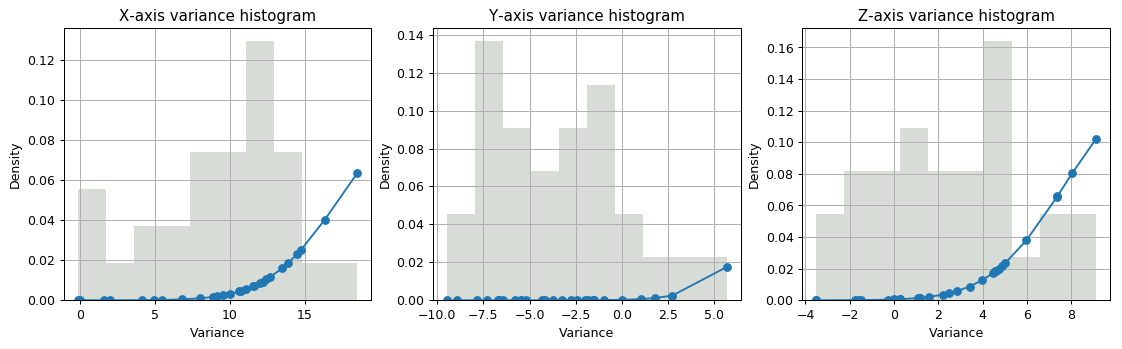

In [108]:
# Calculates the variance for all acceleration axes
vrAccX = calculateVar(series[idxAccX])
vrAccY = calculateVar(series[idxAccY])
vrAccZ = calculateVar(series[idxAccZ])

print("Variance of acceleration\n-----");
print("X-axis: {}".format(vrAccX))
print("Y-axis: {}".format(vrAccY))
print("Z-axis: {}".format(vrAccZ))

%matplotlib inline
plt.figure(figsize=(15, 4), dpi=90)

evaluateVar(series[idxAccX], vrAccX, 'X-axis variance histogram', 1, 3, 1)
evaluateVar(series[idxAccY], vrAccY, 'Y-axis variance histogram', 1, 3, 2)
evaluateVar(series[idxAccZ], vrAccZ, 'Z-axis variance histogram', 1, 3, 3)

Variance of acceleration
-----
X-axis: 3.990580636931388
Y-axis: 3.0703232352440897
Z-axis: 5.006848544017748


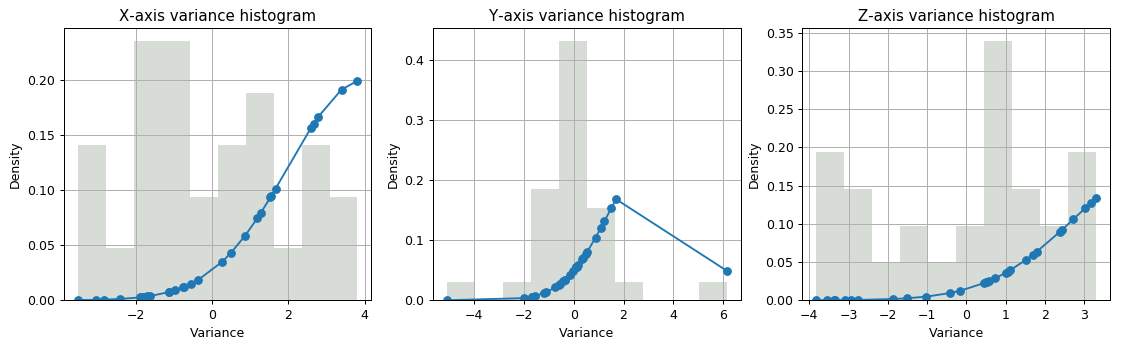

In [112]:
# Calculates the variance for all axes of rotation
vrRotX = calculateVar(series[idxRotX])
vrRotY = calculateVar(series[idxRotY])
vrRotZ = calculateVar(series[idxRotZ])

print("Variance of acceleration\n-----");
print("X-axis: {}".format(vrRotX))
print("Y-axis: {}".format(vrRotY))
print("Z-axis: {}".format(vrRotZ))

%matplotlib inline
plt.figure(figsize=(15, 4), dpi=90)

evaluateVar(series[idxRotX], vrRotX, 'X-axis variance histogram', 1, 3, 1)
evaluateVar(series[idxRotY], vrRotY, 'Y-axis variance histogram', 1, 3, 2)
evaluateVar(series[idxRotZ], vrRotZ, 'Z-axis variance histogram', 1, 3, 3)

## Magnitude of acceleration vector

The `magnitude` gives the length of the vector of each axis of the acceleration of a physical activity.

In [96]:
def calculateMagnitudeOfVector(series):
    return np.linalg.norm(series)

Magnitude of acceleration
-----
X-axis: 57.14763348542791
Y-axis: 26.707211567663183
Z-axis: 22.607841268720907


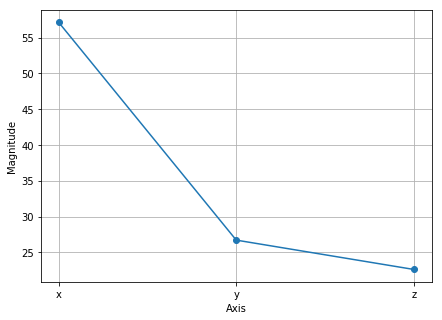

In [113]:
# Calculates the magnitude of acceleration
mvAccX = calculateMagnitudeOfVector(series[idxAccX])
mvAccY = calculateMagnitudeOfVector(series[idxAccY])
mvAccZ = calculateMagnitudeOfVector(series[idxAccZ])

print("Magnitude of acceleration\n-----");
print("X-axis: {}".format(mvAccX))
print("Y-axis: {}".format(mvAccY))
print("Z-axis: {}".format(mvAccZ))

plt.figure(1, figsize=(7, 5))
plt.plot(['x', 'y', 'z'], [mvAccX, mvAccY, mvAccZ], '-o')
plt.xlabel('Axis')
plt.ylabel('Magnitude')
plt.grid()

### Magnitude of the fast Fourier transform of the acceleration

The `magnitude of the fast Fourier transform` of the acceleration of physical motion gives us the length of the straight segment.

In [116]:
def calculateMagnitudeOfFastTransformFourier(series):
    N = len(series)
    fourier = calculateTransformFourier(series)
    
    i = int(N / 2)
    magnitude = (2.0 / N) * np.abs(fourier[0:i])
    return magnitude
    
def evaluateMagnitude(frequency, magnitude, rows, cols, col, color, axis):
    plt.subplot(rows, cols, col)
    plt.plot(frequency, magnitude, color=color)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude of the {}-axis'.format(axis))
    plt.grid()

FFT magnitude of acceleration
-----
X-axis: 1.1780602416954244
Y-axis: 1.4901228841390992
Z-axis: 1.5303778064455507


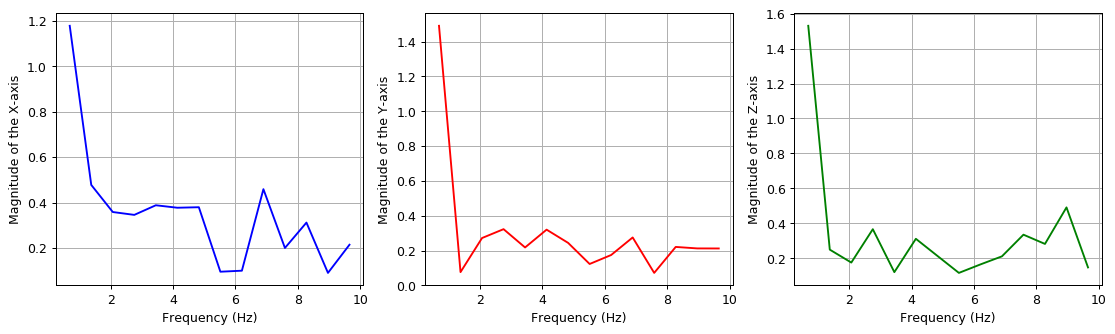

In [117]:
# Calculates the magnitude of the fast fourier transform of the acceleration
mgtAccX = calculateMagnitudeOfFastTransformFourier(series[idxAccX])
mgtAccY = calculateMagnitudeOfFastTransformFourier(series[idxAccY])
mgtAccZ = calculateMagnitudeOfFastTransformFourier(series[idxAccZ])

print("FFT magnitude of acceleration\n-----");
print("X-axis: {}".format(np.max(mgtAccX)))
print("Y-axis: {}".format(np.max(mgtAccY)))
print("Z-axis: {}".format(np.max(mgtAccZ)))

%matplotlib inline
plt.figure(figsize=(15, 4), dpi=90)

evaluateMagnitude(calculateFrequency(series[idxAccX], time_step), mgtAccX, 1, 3, 1, 'blue', 'X')
evaluateMagnitude(calculateFrequency(series[idxAccY], time_step), mgtAccY, 1, 3, 2, 'red', 'Y')
evaluateMagnitude(calculateFrequency(series[idxAccZ], time_step), mgtAccZ, 1, 3, 3, 'green', 'Z')

mgtAccX = np.max(mgtAccX)
mgtAccY = np.max(mgtAccY)
mgtAccZ = np.max(mgtAccZ)

----
# Creating the dataset

After the characteristics are extracted, the data is saved to a .csv file that will be used to train the learning model.

In [118]:
import pandas as pd
import csv

# Vector with the characteristics
data = [time_step, frequency, mnAccX, mnAccY, mnAccZ, mnRotX, mnRotY, mnRotZ, vrAccX, vrAccY, vrAccZ, vrRotX, vrRotY, vrRotZ, mvAccX, mvAccY, mvAccZ, mgtAccX, mgtAccY, mgtAccZ, label]

# Creates the CSV file
with open(u'dataset_final.csv', 'w', newline='') as file:
    fw = csv.writer(file, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)    
    fw.writerow(data)
    
pd.Series(data, index=['time_step','frequency','mnAccX','mnAccY','mnAccZ','mnRotX','mnRotY','mnRotZ','vrAccX','vrAccY','vrAccZ','vrRotX','vrRotY','vrRotZ','mvAccX','mvAccY','mvAccZ','mgtAccX','mgtAccY','mgtAccZ','label'])

time_step                     0.05
frequency                  9.65517
mnAccX                     9.51522
mnAccY                    -3.47589
mnAccZ                     2.57071
mnRotX                  -0.0821748
mnRotY                  -0.0911747
mnRotZ                  0.00514283
vrAccX                     22.0762
vrAccY                     12.5139
vrAccZ                     11.0161
vrRotX                     3.99058
vrRotY                     3.07032
vrRotZ                     5.00685
mvAccX                     57.1476
mvAccY                     26.7072
mvAccZ                     22.6078
mgtAccX                    1.17806
mgtAccY                    1.49012
mgtAccZ                    1.53038
label        andando_passos_longos
dtype: object